## Two Algorithms:

I have two versions of this algorithm 

1. Using laplace noise for all privacy noise. 
2. Using the google privacy accountant to get parameters for gaussian and discrete laplace noise. 

It would be interesting to see if using the gaussian and dlaplace noise instead makes any significant difference 

### Parameters 

- max_depth: How deep the LSH tree should be constructed
- branching_threshold: Minimum number of nodes required to branch
- include_threshold: Minimum number of nodes required to include in final coreset

Algorithm 1: The split of privacy over constructing tree and private averages (default 0.8/0.2)


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from bucket import create_bucket_synopsis, bucket_using_privacy_accountant, Params
from evaluation_utils import kmeans_loss
from lloyd import lloyd_with_weights
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

master_rng = np.random.default_rng(42)

def lsh_experiment(algo: int, data: np.ndarray, p: Params, n_trials: int = 20):
    s = master_rng.integers(low=0, high=100000)
    total_loss = 0
    n_successful_trials = n_trials
    for x in range(n_trials):
        if algo == 1:
            print("starting synopsis... ")
            private_points, private_weights = create_bucket_synopsis(data, p, s+x)
        else:
            private_points, private_weights = create_bucket_synopsis(data, p, s+x)
        if private_points.shape[0] <= p.k: # if number of points is less than or equal to desired number of centers
            centers = private_points
        else:
            centers = lloyd_with_weights(k=p.k, X=private_points, weights=private_weights, n_iter=5, rs=s+x)
        try:
            loss = kmeans_loss(centers, data)
        except:
            loss = 0
            n_successful_trials -=1
        total_loss += loss
        print(f"Trial {x+1} done")
    print("Number completed trials: ", n_successful_trials)
    return total_loss / n_successful_trials


Parameters used 
 max depth: 20
 branching threshold: 138 
 include_threshold: 46
Parameters used 
 max depth: 20
 branching threshold: 138 
 include_threshold: 46
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Printing entire non private tree...
level 0 [(281, '')]
level 1 [(181, '0'), (81, '1')]
level 2 [(-19, '00'), (181, '01')]
level 3 [(20, '010'), (142, '011')]
level 4 [(-19, '0110'), (142, '0111')]
level 5 [(104, '01110'), (19, '01111')]
Algorithm 1 loss: 0.14160255655115378
Algorithm 2 loss: 0.17850822333018249


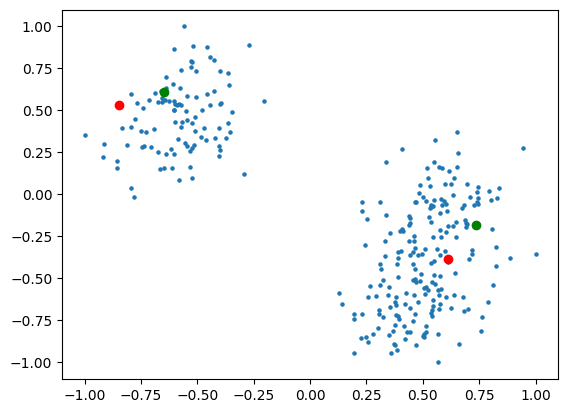

In [4]:
small = np.load("datasets/synthetic-gaussian.npy")
p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=20, include_threshold=46, branching_threshold=138)
points1, weights1 = create_bucket_synopsis(small, p, seed=454)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=454)

# the algorithm only returns 2 points. since we wanted k=3, these points will just become the centers. 
plt.scatter(small[:,0], small[:,1], s=5)
plt.scatter(points1[:,0], points1[:,1], c="red")
plt.scatter(points2[:,0], points2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(points1, small)}")
print(f"Algorithm 2 loss: {kmeans_loss(points2, small)}")

max depth = 5 avg loss = 0.5143181307374742
max depth = 10 avg loss = 0.22169686048146542
max depth = 15 avg loss = 0.15218791393013312
Empty tree gives no centers setting loss to 1
max depth = 20 avg loss = 0.19613573593550737
max depth = 25 avg loss = 0.224526525475283
Empty tree gives no centers setting loss to 1
max depth = 30 avg loss = 0.22579617511845979


Text(0, 0.5, 'k-means loss')

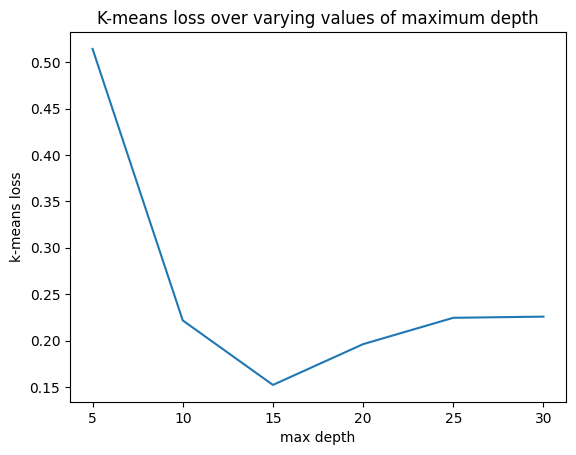

In [16]:
# vary max depth for default branching threshold, include threshold. Note that max depth has to be chosen before computing any noise so it cannot depend on the other parameters

values = [5, 10, 15, 20, 25, 30]
results = []

for d in values:
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=d)
    avg_loss = lsh_experiment(1, small, p, n_trials=50)
    print(f"max depth = {d} avg loss = {avg_loss}")
    results.append(avg_loss)

plt.plot(values, results)
plt.title("K-means loss over varying values of maximum depth")
plt.xlabel("max depth")
plt.ylabel("k-means loss")

starting synopsis... 
Trial 1 done
starting synopsis... 
Trial 2 done
starting synopsis... 
Trial 3 done
starting synopsis... 
Trial 4 done
starting synopsis... 
Trial 5 done
starting synopsis... 
Trial 6 done
starting synopsis... 
Trial 7 done
starting synopsis... 
Trial 8 done
starting synopsis... 
Trial 9 done
starting synopsis... 
Trial 10 done
starting synopsis... 
Trial 11 done
starting synopsis... 
Trial 12 done
starting synopsis... 
Trial 13 done
starting synopsis... 
Trial 14 done
starting synopsis... 
Trial 15 done
starting synopsis... 
Trial 16 done
starting synopsis... 
Trial 17 done
starting synopsis... 
Trial 18 done
starting synopsis... 
Trial 19 done
starting synopsis... 
Trial 20 done
starting synopsis... 
Trial 21 done
starting synopsis... 
Trial 22 done
starting synopsis... 
Trial 23 done
starting synopsis... 
Trial 24 done
starting synopsis... 
Trial 25 done
starting synopsis... 
Trial 26 done
starting synopsis... 
Trial 27 done
starting synopsis... 
Trial 28 done
s

Text(0, 0.5, 'k-means loss')

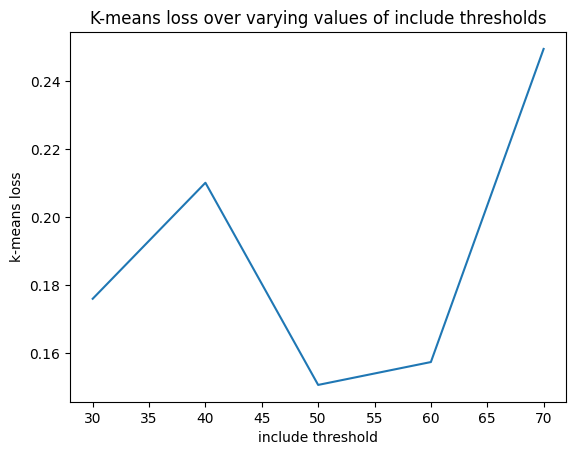

In [8]:
include_thresholds = [30, 40, 50, 60, 70]
results_depth15 = []
results_depth20 = []
results_depth25 = []

for i in include_thresholds:
    p15 = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=15)
    p20 = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth= 20)
    p25 = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=25)
    avg_loss = lsh_experiment(1, small, p15, n_trials=30)
    results_depth15.append(avg_loss)
    avg_loss = lsh_experiment(1, small, p20, n_trials=30)
    results_depth20.append(avg_loss)
    avg_loss = lsh_experiment(1, small, p25, n_trials=30)
    results_depth25.append(avg_loss)



plt.plot(include_thresholds, results)
plt.title("K-means loss over varying values of include thresholds")
plt.xlabel("include threshold")
plt.ylabel("k-means loss")

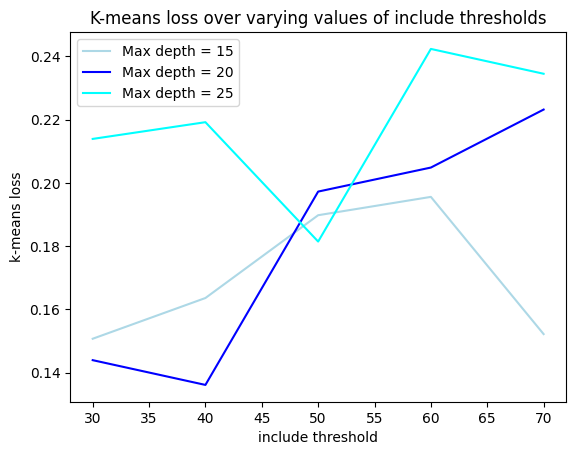

In [10]:
plt.plot(include_thresholds, results_depth15, c="lightblue")
plt.plot(include_thresholds, results_depth20, c="blue")
plt.plot(include_thresholds, results_depth25, c="cyan")
plt.title("K-means loss over varying values of include thresholds")
plt.xlabel("include threshold")
plt.ylabel("k-means loss")
plt.legend(["Max depth = 15", "Max depth = 20", "Max depth = 25"])

### Airports Dataset

Parameters used 
 max depth: 20
 branching threshold: 120.0 
 include_threshold: 40.0
Parameters used 
 max depth: 20
 branching threshold: 120.0 
 include_threshold: 40.0
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Printing entire non private tree...
level 0 [(345, '')]
level 1 [(239, '0'), (151, '1')]
level 2 [(45, '00'), (239, '01'), (145, '10'), (51, '11')]
level 3 [(45, '010'), (239, '011'), (145, '100'), (45, '101')]
level 4 [(45, '0110'), (239, '0111'), (145, '1000'), (45, '1001')]
level 5 [(45, '01110'), (239, '01111'), (145, '10000'), (45, '10001')]
level 6 [(239, '011110'), (45, '011111'), (45, '100000'), (145, '100001')]
level 7 [(174, '0111100'), (110, '0111101'), (65, '1000010'), (125, '1000011')]
level 8 [(45, '01111000'), (174, '01111001'), (125, '10000110'), (45, '10000111')]
level 9 [(45, '011110010'), (174, '011110011'), (125, '100001100'), (45, '100001101')]
level 10 [(

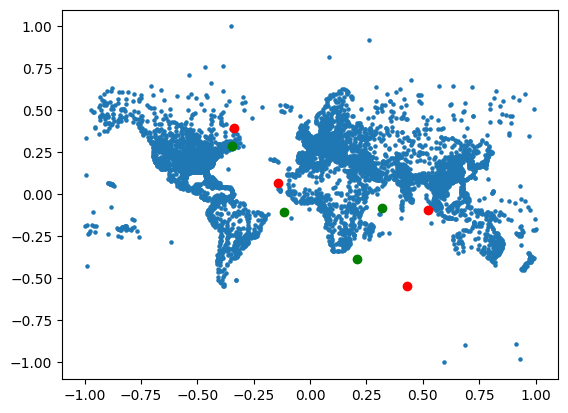

In [6]:
airports = np.load("datasets/airports.npy")
k=4
p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=k)
points1, weights1 = create_bucket_synopsis(small, p, seed=421231)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=421231)
if len(points1) > k:
    centers1 = KMeans(k).fit(points1, sample_weight=weights1).cluster_centers_
else:
    centers1 = points1
if len(points2) > k:
    centers2 = KMeans(k).fit(points2, sample_weight=weights2).cluster_centers_
else:
    centers2 = points2

plt.scatter(airports[:,0], airports[:,1], s=5)
plt.scatter(centers1[:,0], centers1[:,1], c="red")
plt.scatter(centers2[:,0], centers2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(centers1, airports)}")
print(f"Algorithm 2 loss: {kmeans_loss(centers2, airports)}")

### Iris Dataset

In [ ]:

iris = np.load("datasets/iris.npy")

Parameters used 
 max depth: 20
 branching threshold: 171 
 include_threshold: 57
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Printing entire non private tree...
level 0 [(229, '')]
level 1 [(182, '0'), (126, '1')]
level 2 [(127, '00'), (134, '01')]


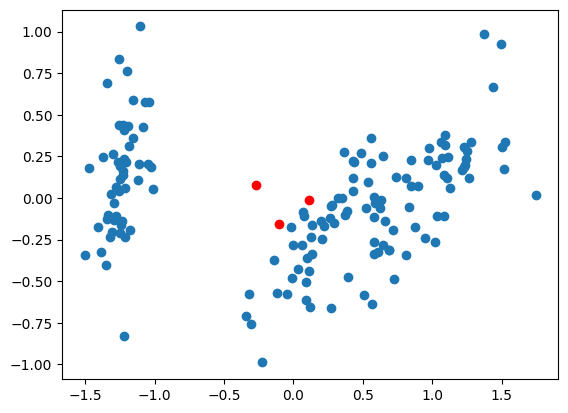

In [10]:
iris_pca = PCA(n_components=2)
iris_2d = iris_pca.fit_transform(iris)

params = Params(epsilon=1, delta=1e-6, radius=1, dimension=4, k=2)
points, weights = bucket_using_privacy_accountant(X=iris, p=params, seed=5435)

plt.scatter(iris_2d[:,0], iris_2d[:,1])
plt.scatter(points[:,0], points[:,1], c="red")

### Large Synthetic 

In [21]:
large = np.load("datasets/large-synthetic.npy")
large.shape

np.max(np.linalg.norm(large, axis=-1)) # radius of 2.3

np.float64(4.673602230380081)

Parameters used 
 max depth: 20
 branching threshold: 1299 
 include_threshold: 433
pcalc AveragePrivacyParam(gaussian_standard_deviation=20.389098119633637, sensitivity=4.7) CountPrivacyParam(dlaplace_param=0.011525767281177938)


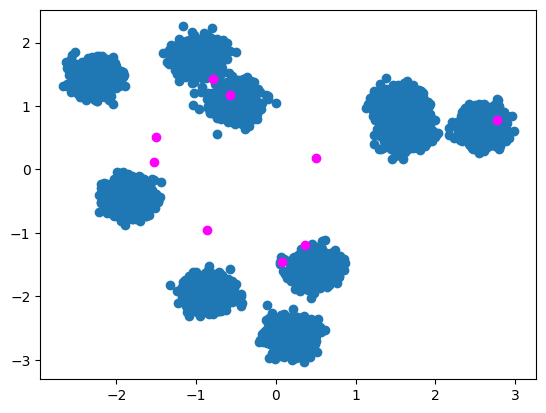

In [23]:
large_pca = PCA(n_components=2)
large_2d = large_pca.fit_transform(large)

params = Params(epsilon=1, delta=1e-6, radius=4.7, dimension=100, k=10)
points, weights = bucket_using_privacy_accountant(X=large, p=params, seed=21375)
if len(points) > 10:
    centers = KMeans(10).fit(points, sample_weight=weights).cluster_centers_
else:
    centers = points
centers_2d = large_pca.transform(centers)

plt.scatter(large_2d[:,0], large_2d[:,1])
plt.scatter(centers_2d[:,0], centers_2d[:, 1], c="magenta")

In [ ]:
forest = np.load("datasets/forest.npy")
forest.shape

np.max(np.linalg.norm(forest, axis=-1)) # radius of 2.3

np.float64(2.3357579993966078)

Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
[259.35959421 529.35959421 267.35959421 355.35959421 486.35959421
 530.35959421 356.35959421 552.35959421 566.35959421 447.35959421
 494.35959421 586.35959421 347.35959421 464.35959421 521.35959421
 470.35959421 597.35959421 447.35959421 353.35959421]


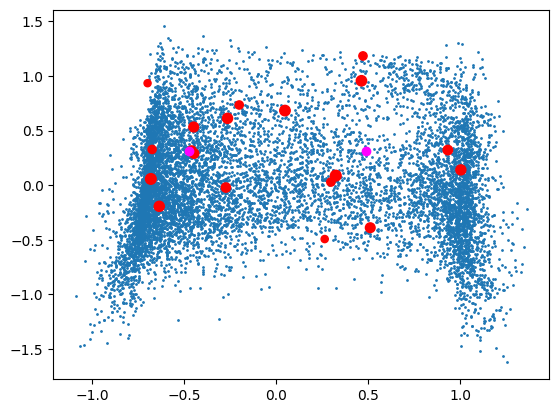

In [20]:
from sklearn.cluster import KMeans

forest_pca = PCA(n_components=2)
forest_2d = forest_pca.fit_transform(forest)

params = Params(epsilon=1, delta=1e-6, radius=2.4, dimension=9, k=2, include_threshold=200)
points, weights = create_bucket_synopsis(X=forest, p=params, seed=21375, privacy_split=0.5)
centers = KMeans(n_clusters=2, init="k-means++").fit(points, sample_weight=weights).cluster_centers_
centers_2d = forest_pca.transform(centers)
points_2d = forest_pca.transform(points)

plt.scatter(forest_2d[:,0], forest_2d[:,1], s=1)
plt.scatter(points_2d[:,0], points_2d[:, 1], s=abs(weights)*0.1, c="red")
plt.scatter(centers_2d[:,0], centers_2d[:, 1], c="magenta")

print(weights)

In [16]:
# try different values of include threshold

thresholds = [200, 225, 250, 300, 400, 500, 600]
results = []

for i in thresholds:
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=9, k=2, include_threshold=i)
    avg_loss = lsh_experiment(algo=1, data=forest, p=p, n_trials=50)
    results.append(avg_loss)

starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 20
 b

[np.float64(1.116478079577987), np.float64(1.1407056410887424), np.float64(1.0959751267203155), np.float64(1.0622742835053947), np.float64(1.0577344190342046), np.float64(1.0494759867499979), np.float64(1.0349805752084922)]


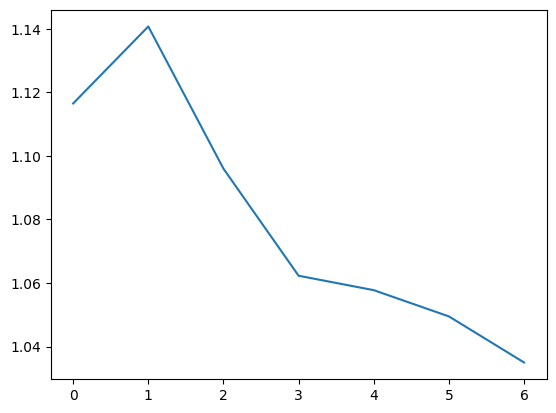

In [17]:
plt.plot(results)
print(results)

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler 

gen = np.random.default_rng(78)

x1 = gen.multivariate_normal(np.ones(100), np.identity(100), 10000)

x2 = gen.multivariate_normal(-1*np.ones(100), np.identity(100), 10000)

x = np.concat([x1, x2])
x = MinMaxScaler((-1,1)).fit_transform(x)

p = Params(epsilon=10, delta=1e-6, radius=1, dimension=100, k=2)

points, weights = create_bucket_synopsis(x, p, seed=68724)

centers = lloyd_with_weights(2, points, weights, 10, 23)

KMeans(2).fit(x).cluster_centers_
print(centers)

Parameters used 
 max depth: 20
 branching threshold: 150 
 include_threshold: 50
[[ 2.93047150e-02  8.17538182e-02 -2.05668698e-02  5.20028350e-02
   2.05215798e-01  4.69644518e-02  1.28735333e-02 -1.36740513e-02
  -1.06728017e-01  9.84833397e-02 -8.09277711e-02  4.86935448e-02
   1.15131808e-02  4.22132232e-03 -1.87314314e-01 -1.72579098e-01
  -4.19898327e-02 -6.51023348e-03 -1.23519935e-01  8.43096366e-03
  -1.46619829e-01 -2.73423350e-02  6.18825147e-02 -3.75668111e-02
  -1.25261390e-01 -1.24774086e-01  8.00118142e-02 -4.36465949e-02
  -4.54554038e-02  9.28328864e-02 -1.06236021e-01  1.30091290e-01
   2.87071549e-02  3.51252226e-02  2.81061943e-02  8.86365036e-02
  -4.35984829e-02 -2.98445593e-04  1.79783630e-01  3.68889618e-03
   2.06406616e-02 -1.37601800e-01 -6.71357048e-03  1.94114137e-01
  -2.12478083e-03 -7.41854638e-03  2.31789180e-02  3.82366544e-02
  -5.87881284e-02 -3.13798246e-02 -8.11676826e-03  6.39452582e-02
   2.18126824e-05 -7.83793645e-04  2.37588121e-01 -8.0642646

Parameters used 
 max depth: 20
 branching threshold: 411 
 include_threshold: 137
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
[[-0.31170619 -0.31150987 -0.31574941 -0.29648137 -0.29647113 -0.32847424
  -0.30547118 -0.31206204 -0.30722417 -0.29270889]
 [ 0.31581327  0.30169     0.29218581  0.29686539  0.31815571  0.31357562
   0.32006042  0.30147231  0.31242192  0.3019318 ]]
[[ 0.2867055   0.28628945  0.28752715  0.28827828  0.2855829   0.28673532
   0.28833826  0.28837735  0.28719105  0.28936919]
 [-0.28884448 -0.28833847 -0.28785159 -0.28641883 -0.28818372 -0.2882993
  -0.28744137 -0.28740061 -0.28670743 -0.28600053]]


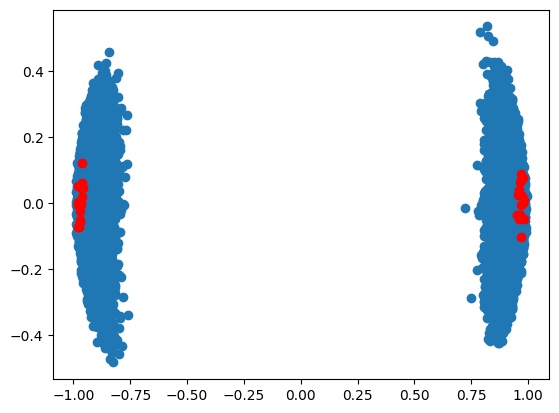

In [13]:
z1 = gen.uniform(low=-1, high=-0.1, size=(10000,10))
z2 = gen.uniform(low=0.1, high=1, size=(10000,10))
z = np.concat([z1, z2])

scale = 1 / np.maximum(
        np.linalg.norm(z, axis=-1), 1
    ).reshape(-1, 1)
z = z * scale

pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)
plt.scatter(z_2d[:,0], z_2d[:,1])

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=10, k=2)
points, weights = bucket_using_privacy_accountant(z, p, seed=2123)
points_2d = pca.transform(points)
plt.scatter(points_2d[:,0], points_2d[:,1], c="red")
points.shape

centers = KMeans(2).fit(points, sample_weight=weights).cluster_centers_
print(centers)

real_centers = KMeans(2).fit(z).cluster_centers_
print(real_centers)

In [12]:
# scale z so it is definitely in that radius

scale = 1 / np.maximum(
        np.linalg.norm(z, axis=-1), 1
    ).reshape(-1, 1)
z_scaled = z * scale

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=10, k=2)
points, weights = bucket_using_privacy_accountant(z_scaled, p, seed=2123)
centers = KMeans(2).fit(points, sample_weight=weights).cluster_centers_
print(centers)

real_centers = KMeans(2).fit(z_scaled).cluster_centers_
print(real_centers)

Parameters used 
 max depth: 20
 branching threshold: 411 
 include_threshold: 137
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
[[ 0.31935227  0.30268037  0.2967799   0.29397793  0.32211033  0.31729504
   0.3211759   0.30029292  0.30448614  0.29820318]
 [-0.30818741 -0.3114068  -0.31329431 -0.30177599 -0.295111   -0.32850661
  -0.30143428 -0.3119433  -0.3077515  -0.29835025]]
[[ 0.28886707  0.287928    0.2880989   0.28818325  0.28781475  0.28900722
   0.28701287  0.28521865  0.28674588  0.28684429]
 [-0.28560289 -0.28732374 -0.28698842 -0.28873711 -0.28779413 -0.28670182
  -0.28597476 -0.28836744 -0.28747737 -0.29075439]]


Parameters used 
 max depth: 20
 branching threshold: 183 
 include_threshold: 61
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Printing entire non private tree...
level 0 [(20002, '')]
level 1 [(10015, '0'), (9989, '1')]
level 2 [(5661, '00'), (4356, '01'), (4360, '10'), (5631, '11')]
level 3 [(3494, '000'), (2169, '001'), (4356, '010'), (2, '011'), (2, '100'), (4360, '101'), (2156, '110'), (3477, '111')]
level 4 [(3494, '0000'), (2, '0001'), (2, '0010'), (2169, '0011'), (4356, '0100'), (2, '0101'), (2, '1010'), (4360, '1011'), (2156, '1100'), (2, '1101'), (2, '1110'), (3477, '1111')]
level 5 [(3109, '00000'), (387, '00001'), (2, '00110'), (2169, '00111'), (4356, '01000'), (2, '01001'), (2, '10110'), (4360, '10111'), (2156, '11000'), (2, '11001'), (395, '11110'), (3084, '11111')]
level 6 [(2, '000000'), (3109, '000001'), (2, '000010'), (387, '000011'), (2169, '001110'), (2, '001111'), (2, 

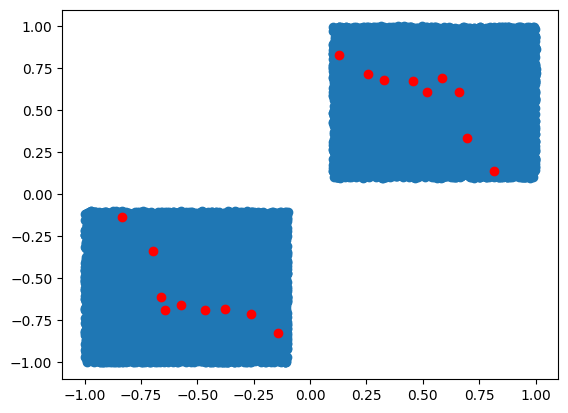

In [21]:
z1 = gen.uniform(low=-1, high=-0.1, size=(10000,2))
z2 = gen.uniform(low=0.1, high=1, size=(10000,2))
z = np.concat([z1, z2])
z_2d = z
plt.scatter(z_2d[:,0], z_2d[:,1])

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=2)
points, weights = bucket_using_privacy_accountant(z, p, seed=7634)
points_2d = points
plt.scatter(points_2d[:,0], points_2d[:,1], c="red")